In [57]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [58]:
# The actual prior variance

prior_var = 1

use_marcels_colorscheme = True

In [59]:
# This function estimates the expectation by evaluating the estimated variance 
# multiple times and returning the mean

def sim(prop_prior_var, N, nsamples=1000):
    mles = np.empty(nsamples)
    
    for i in range(nsamples):
        xlist = np.random.normal(scale = np.sqrt(prop_prior_var), size=N)
        d = 1 / prop_prior_var - 1 / prior_var
        wlist = np.sqrt(prop_prior_var / prior_var) * np.exp(d / 2 * (xlist ** 2))

        var_mle = np.sum((xlist ** 2) * wlist) / np.sum(wlist)
        mles[i] = var_mle
    
    return np.mean(mles)

def sim_with_defensive(prop_prior_var, N, alpha, nsamples=1000):
    npsamples = int(N * alpha)
    nppsamples = N - npsamples
    mles = np.empty(nsamples)
    
    for i in range(nsamples):
        xlist = np.concatenate((np.random.normal(scale = np.sqrt(prop_prior_var), size=nppsamples),
                                np.random.normal(scale = np.sqrt(prior_var), size=npsamples)))
        d = 1 / prop_prior_var - 1 / prior_var
        wlist = np.concatenate((np.sqrt(prop_prior_var / prior_var) * np.exp(d / 2 * (xlist[:nppsamples] ** 2)),
                                np.ones(npsamples) ))

        var_mle = np.sum((xlist ** 2) * wlist) / np.sum(wlist)
        mles[i] = var_mle
    
    return np.mean(mles)

In [60]:
# This function estimates the expectation using the formula and MC integration

def calc(prop_prior_var, N, nsamples=100000):
    xlist = np.random.normal(scale = np.sqrt(prior_var), size=nsamples)
    d = 1 / prop_prior_var - 1 / prior_var
    wlist = np.sqrt(prop_prior_var / prior_var) * np.exp(d / 2 * (xlist ** 2))
    ylist = (xlist ** 2) / (1 + (wlist - 1) / N)
    
    return np.mean(ylist)

def calc_with_defensive(prop_prior_var, N, alpha, nsamples=100000):
    xlist = np.random.normal(scale = np.sqrt(prior_var), size=nsamples)
    d = 1 / prop_prior_var - 1 / prior_var
    wlist = 1 / (alpha + (1 - alpha) / np.sqrt(prop_prior_var / prior_var) * np.exp(d / 2 * (xlist ** 2)))
    ylist = (xlist ** 2) / (1 + (wlist - 1) / N)
    
    return np.mean(ylist)

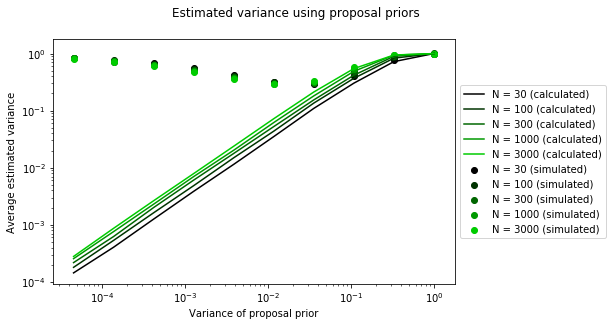

In [62]:
fig, ax = plt.subplots(1, figsize = (9,4.5))

# List of proposal prior variances (x-axis)
vlist = prior_var * np.exp(-np.linspace(0, 10, 10))

Nlist = [ 30, 100, 300, 1000, 3000 ]

for j in range(len(Nlist)):
    calc_list = [ sim(i, Nlist[j]) for i in vlist]
    sim_list = [ sim_with_defensive(i, Nlist[j], 0.1) for i in vlist]
    
    color = None
    if use_marcels_colorscheme:
        color = [0,j / len(Nlist),0]
    ax.loglog(vlist, calc_list, label="N = {} (calculated)".format(Nlist[j]), color=color)
    ax.scatter(vlist, sim_list, label="N = {} (simulated)".format(Nlist[j]), color=color)
    
fig.suptitle("Estimated variance using proposal priors")

ax.set_ylabel("Average estimated variance")
ax.set_xlabel("Variance of proposal prior")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Plot sds